In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
from baryrat import aaa

%matplotlib inline

from src.helpers import calculate_relgap, plot_eigenvalues, get_FD_matrix
from src.experiments import get_bound_chebyshev, get_test_matrices, get_convergence
from src.solvers import Phi, Cosine, CosineSqrt, Sine, Sinc, Sinc2

In [2]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Reading the test matrices

In [3]:
# orani678 = sp.io.mmread('data/orani678.mtx').tocsc()
# bcspwr10 = sp.io.mmread('data/bcspwr10.mtx').tocsc()
# gr_30_30 = sps.csc_matrix(sp.io.mmread('data/gr_30_30.mtx').toarray().astype(np.float64))  # NOTE: Stored as int
# helm2d03 = sp.io.mmread('data/helm2d03.mtx').tocsc()

In [3]:
A_LE = {}
for h in [0.1, 0.07, 0.04]:
    # Read the matrix and its vectors
    A_LE[h] = sp.io.loadmat(f'data/h{h:.0e}.mat', appendmat=False)
    A = A_LE[h]['A'].toarray()

    # Reshape the vectors
    A_LE[h]['u0'] = A_LE[h]['u0'].reshape(-1)
    A_LE[h]['v0'] = A_LE[h]['v0'].reshape(-1)
    A_LE[h]['b'] = A_LE[h]['b'].reshape(-1)

    # Rectify the matrix
    tol = 1e-02
    assert sp.linalg.issymmetric(A, atol=tol, rtol=0)
    A[np.abs(A) < tol] = 0
    A = (sps.tril(A) + sps.tril(A).T).toarray()

    # Get the square root of the matrix and make it symmetric
    H = sp.linalg.sqrtm(A)
    # tol = 1e-08
    # assert sp.linalg.issymmetric(H, atol=tol, rtol=0)
    # H = sps.tril(H) + sps.tril(H).T

    # Compute its eigenvalues and eigenvectors
    dA, SA = sp.linalg.eigh(A)
    dH, SH = sp.linalg.eigh(H)

    # Store the rectified matrix and its square root
    A_LE[h]['A'] = sps.csc_matrix(A)
    A_LE[h]['H'] = sps.csc_matrix(H)

    # Store the eigenvalues and eigenvectors
    A_LE[h]['dA'] = dA
    A_LE[h]['SA'] = SA
    A_LE[h]['dH'] = dH
    A_LE[h]['SH'] = SH

# Properties of the test matrices

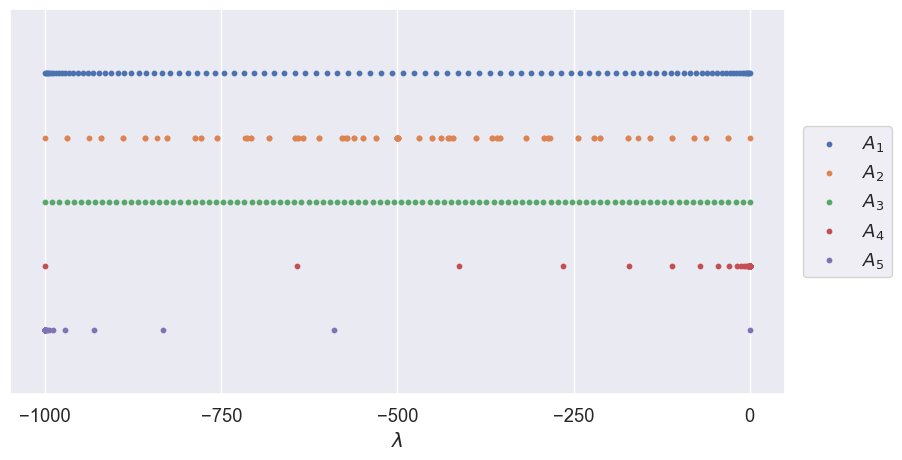

In [7]:
# Eigenvalue distribution

plot_eigenvalues(
    As=[*get_test_matrices(n=100, interval=(-1000, 0))],
    legends=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$'],
    xticks=[-1000, -750, -500, -250, 0],
    # range_=(-1000, 0),
)

# plot_eigenvalues(
#     As=[A_LE[h]['A'] for h in [0.1, 0.07, 0.04]],
#     legends=['$A_{LE}^{0.10}$', '$A_{LE}^{0.07}$', '$A_{LE}^{0.04}$'],
# )

# plot_eigenvalues(
#     As=[A_LE[h]['H'] for h in [0.1, 0.07, 0.04]],
#     legends=['$H_{LE}^{0.10}$', '$H_{LE}^{0.07}$', '$H_{LE}^{0.04}$'],
# )

In [ ]:
# Relative gap

names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']
data = {'n': [], 'Matrix': [], 'g_l': [], 'g_r': []}
a, b = (-1000, -1e-00)
for n in [n ** 2 for n in [6, 7, 8, 9, 10, 12, 14, 16, 20, 30, 40, 50, 60]]:
    I = sps.identity(n=n)
    for idx, A in enumerate(get_test_matrices(n=n, interval=(a, b))):
        data['n'].append(n)
        data['Matrix'].append(names[idx])
        g_l, g_r = calculate_relgap(A, lam_min1=a, lam_max1=b)
        data['g_l'].append(g_l)
        data['g_r'].append(g_r)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_l', hue='Matrix', ax=axs[0])
axs[0].set(yscale='log', ylabel='$\gamma_L$', xlabel='n')
sns.lineplot(data=pd.DataFrame(data), x='n', y='g_r', hue='Matrix', ax=axs[1])
axs[1].set(yscale='log', ylabel='$\gamma_R$', xlabel='n')
for ax in axs:
    ax.legend()

# Scalar $\varphi$-functions

## On the left complex half plane

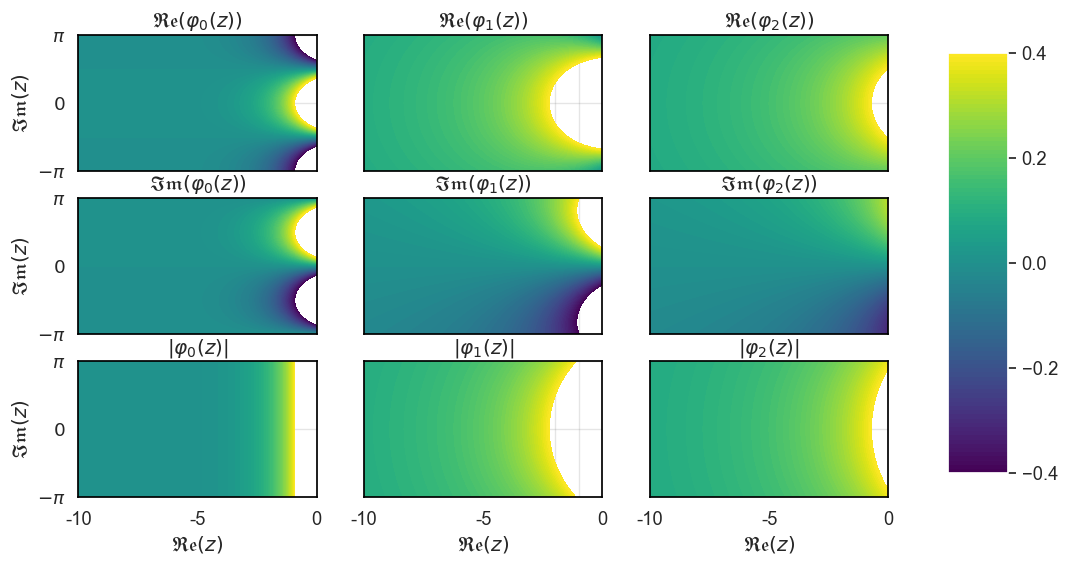

In [3]:
a = np.linspace(-10, 0, 101)
b = np.linspace(-np.pi, np.pi, 101)
a, b = np.meshgrid(a, b)
z = a + 1j * b

ps = [0, 1, 2]
cbarmarg = (-.4, +.4)
levels = np.linspace(cbarmarg[0], cbarmarg[1], 101)

fig, axs = plt.subplots(nrows=3, ncols=len(ps), figsize=(12, 6), sharey=True, sharex=True)
for idx, p in enumerate(ps):
    f = Phi(p=p)
    r = f.scalar(z)

    cmap = 'viridis'
    norm='linear'
    h0 = axs[0, idx].contourf(z.real, z.imag, r.real, levels=levels, cmap=cmap, norm=norm)
    h1 = axs[1, idx].contourf(z.real, z.imag, r.imag, levels=levels, cmap=cmap, norm=norm)
    h1 = axs[2, idx].contourf(z.real, z.imag, np.abs(r), levels=levels, cmap=cmap, norm=norm)
    axs[0, idx].set(title=f'$\\mathfrak{{Re}}(\\varphi_{f.p}(z))$')
    axs[1, idx].set(title=f'$\\mathfrak{{Im}}(\\varphi_{f.p}(z))$')
    axs[2, idx].set(title=f'$|\\varphi_{f.p}(z)|$')

for ax in axs[-1, :]:
    ax.set(xlabel='$\\mathfrak{Re}(z)$', xticks=[-10, -5, -4, -3, -2, -1, 0], xticklabels=[-10, -5, '', '', '', '', 0])
for ax in axs[:, 0]:
    ax.set(ylabel='$\\mathfrak{Im}(z)$', yticks=[-np.pi, 0, np.pi], yticklabels=['$-\pi$', '$0$', '$\pi$'])
for ax in axs.flat:
    ax.grid(color='gray', alpha=.2)
    ax.set(facecolor='white', axisbelow=True)
    for spine in ax.spines.values():
        spine.set_color('black')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(h0, cax=cbar_ax, ticks=[cbarmarg[0], (cbarmarg[0] / 2), 0, (cbarmarg[1] / 2), cbarmarg[1]])

## In proximity of zero

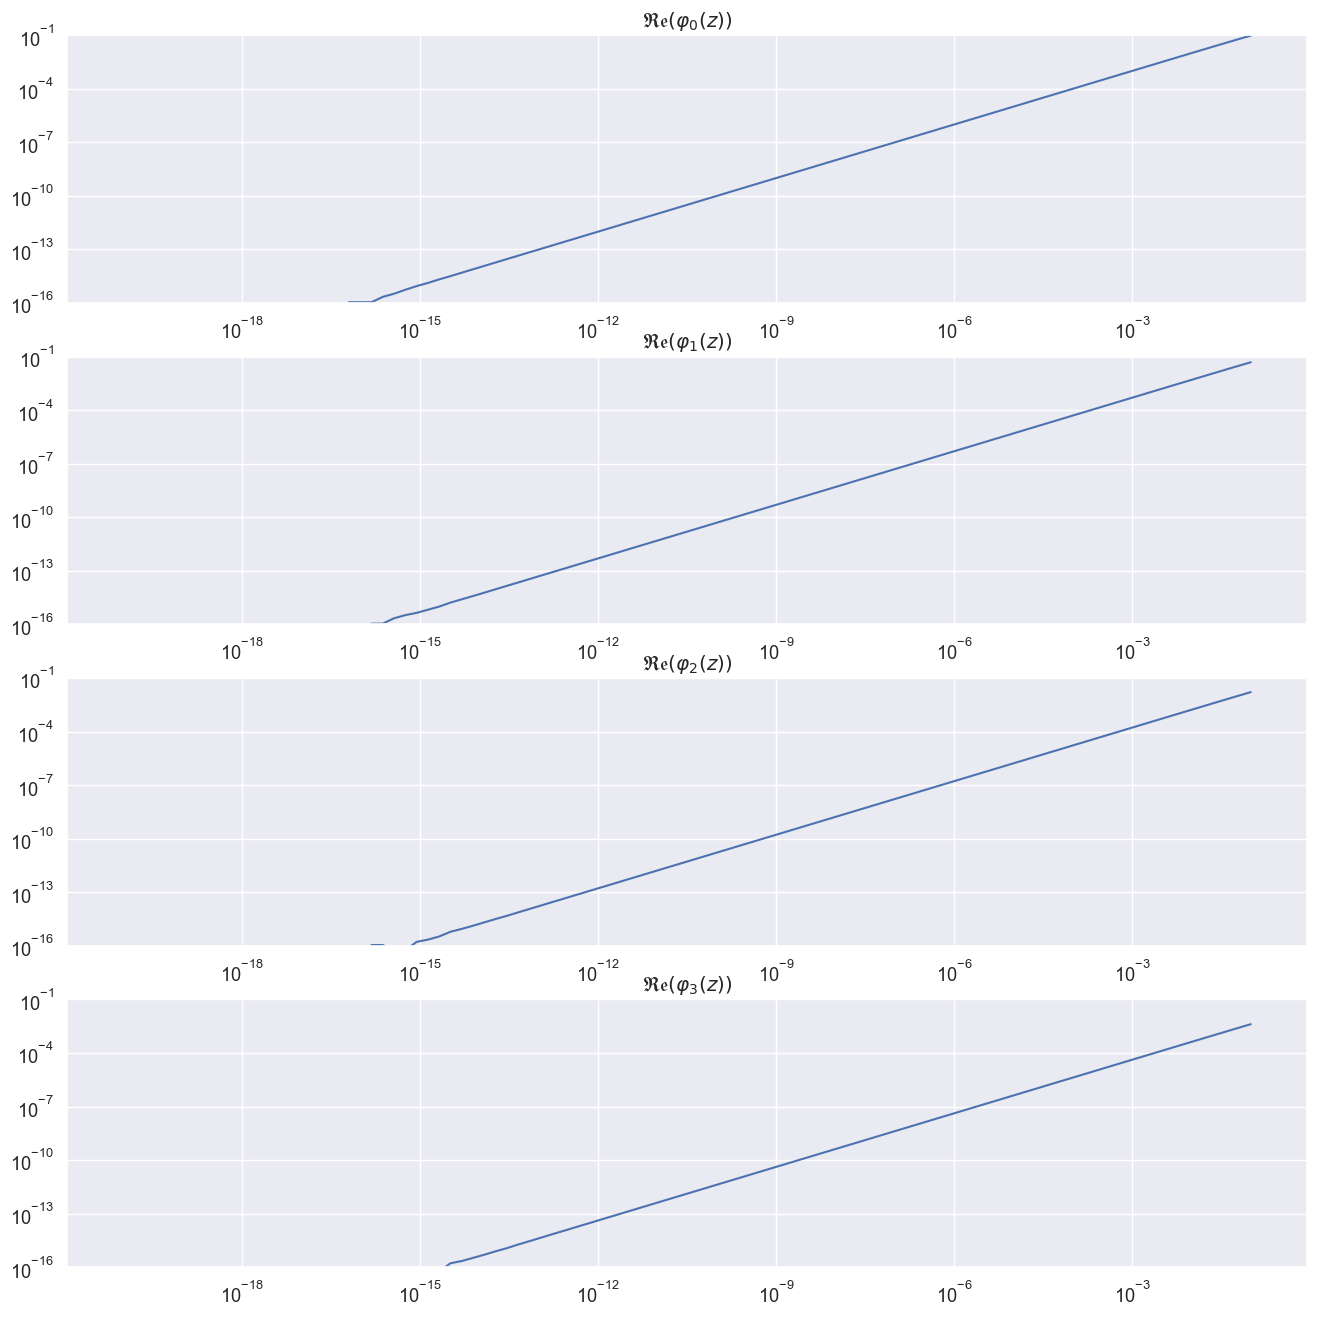

In [4]:
a = np.logspace(-1, -20, 101)
z = -a

ps = [0, 1, 2, 3]
eps = 1e-02
cbarmarg = (-eps, +eps)
levels = np.linspace(cbarmarg[0], cbarmarg[1], 101)

fig, axs = plt.subplots(ncols=1, nrows=len(ps), figsize=(16, 16), sharey=False, sharex=False)
for idx, p in enumerate(ps):
    f = Phi(p=p)
    r = np.abs(
        f.scalar(z)
        - 1 / np.math.factorial(f.p)
    )

    h0 = axs[idx].plot(a, r)
    axs[idx].set(title=f'$\\mathfrak{{Re}}(\\varphi_{f.p}(z))$')

for ax in axs.flat:
    ax.set(xscale='log', yscale='log', ylim=[1e-16, 1e-01])

# The AAA algorithm

## What happens to `m` poles when $a \to -\infty$?

In [ ]:
m = 10

nodes = []
poles_real = []
poles_imag = []
errors = []
ps = []
as_ = []
for a in tqdm(np.geomspace(1e02, 3e04, 10)):
    for p in [0, 1, 3, 5]:
        f = Phi(p=p)
        Z = np.linspace(-a, 0, int(a))
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        nodes.append(r.nodes)
        poles_real.append(r.poles().real)
        poles_imag.append(r.poles().imag)
        errors.append(e)
        ps.append(p)
        as_.append(a)

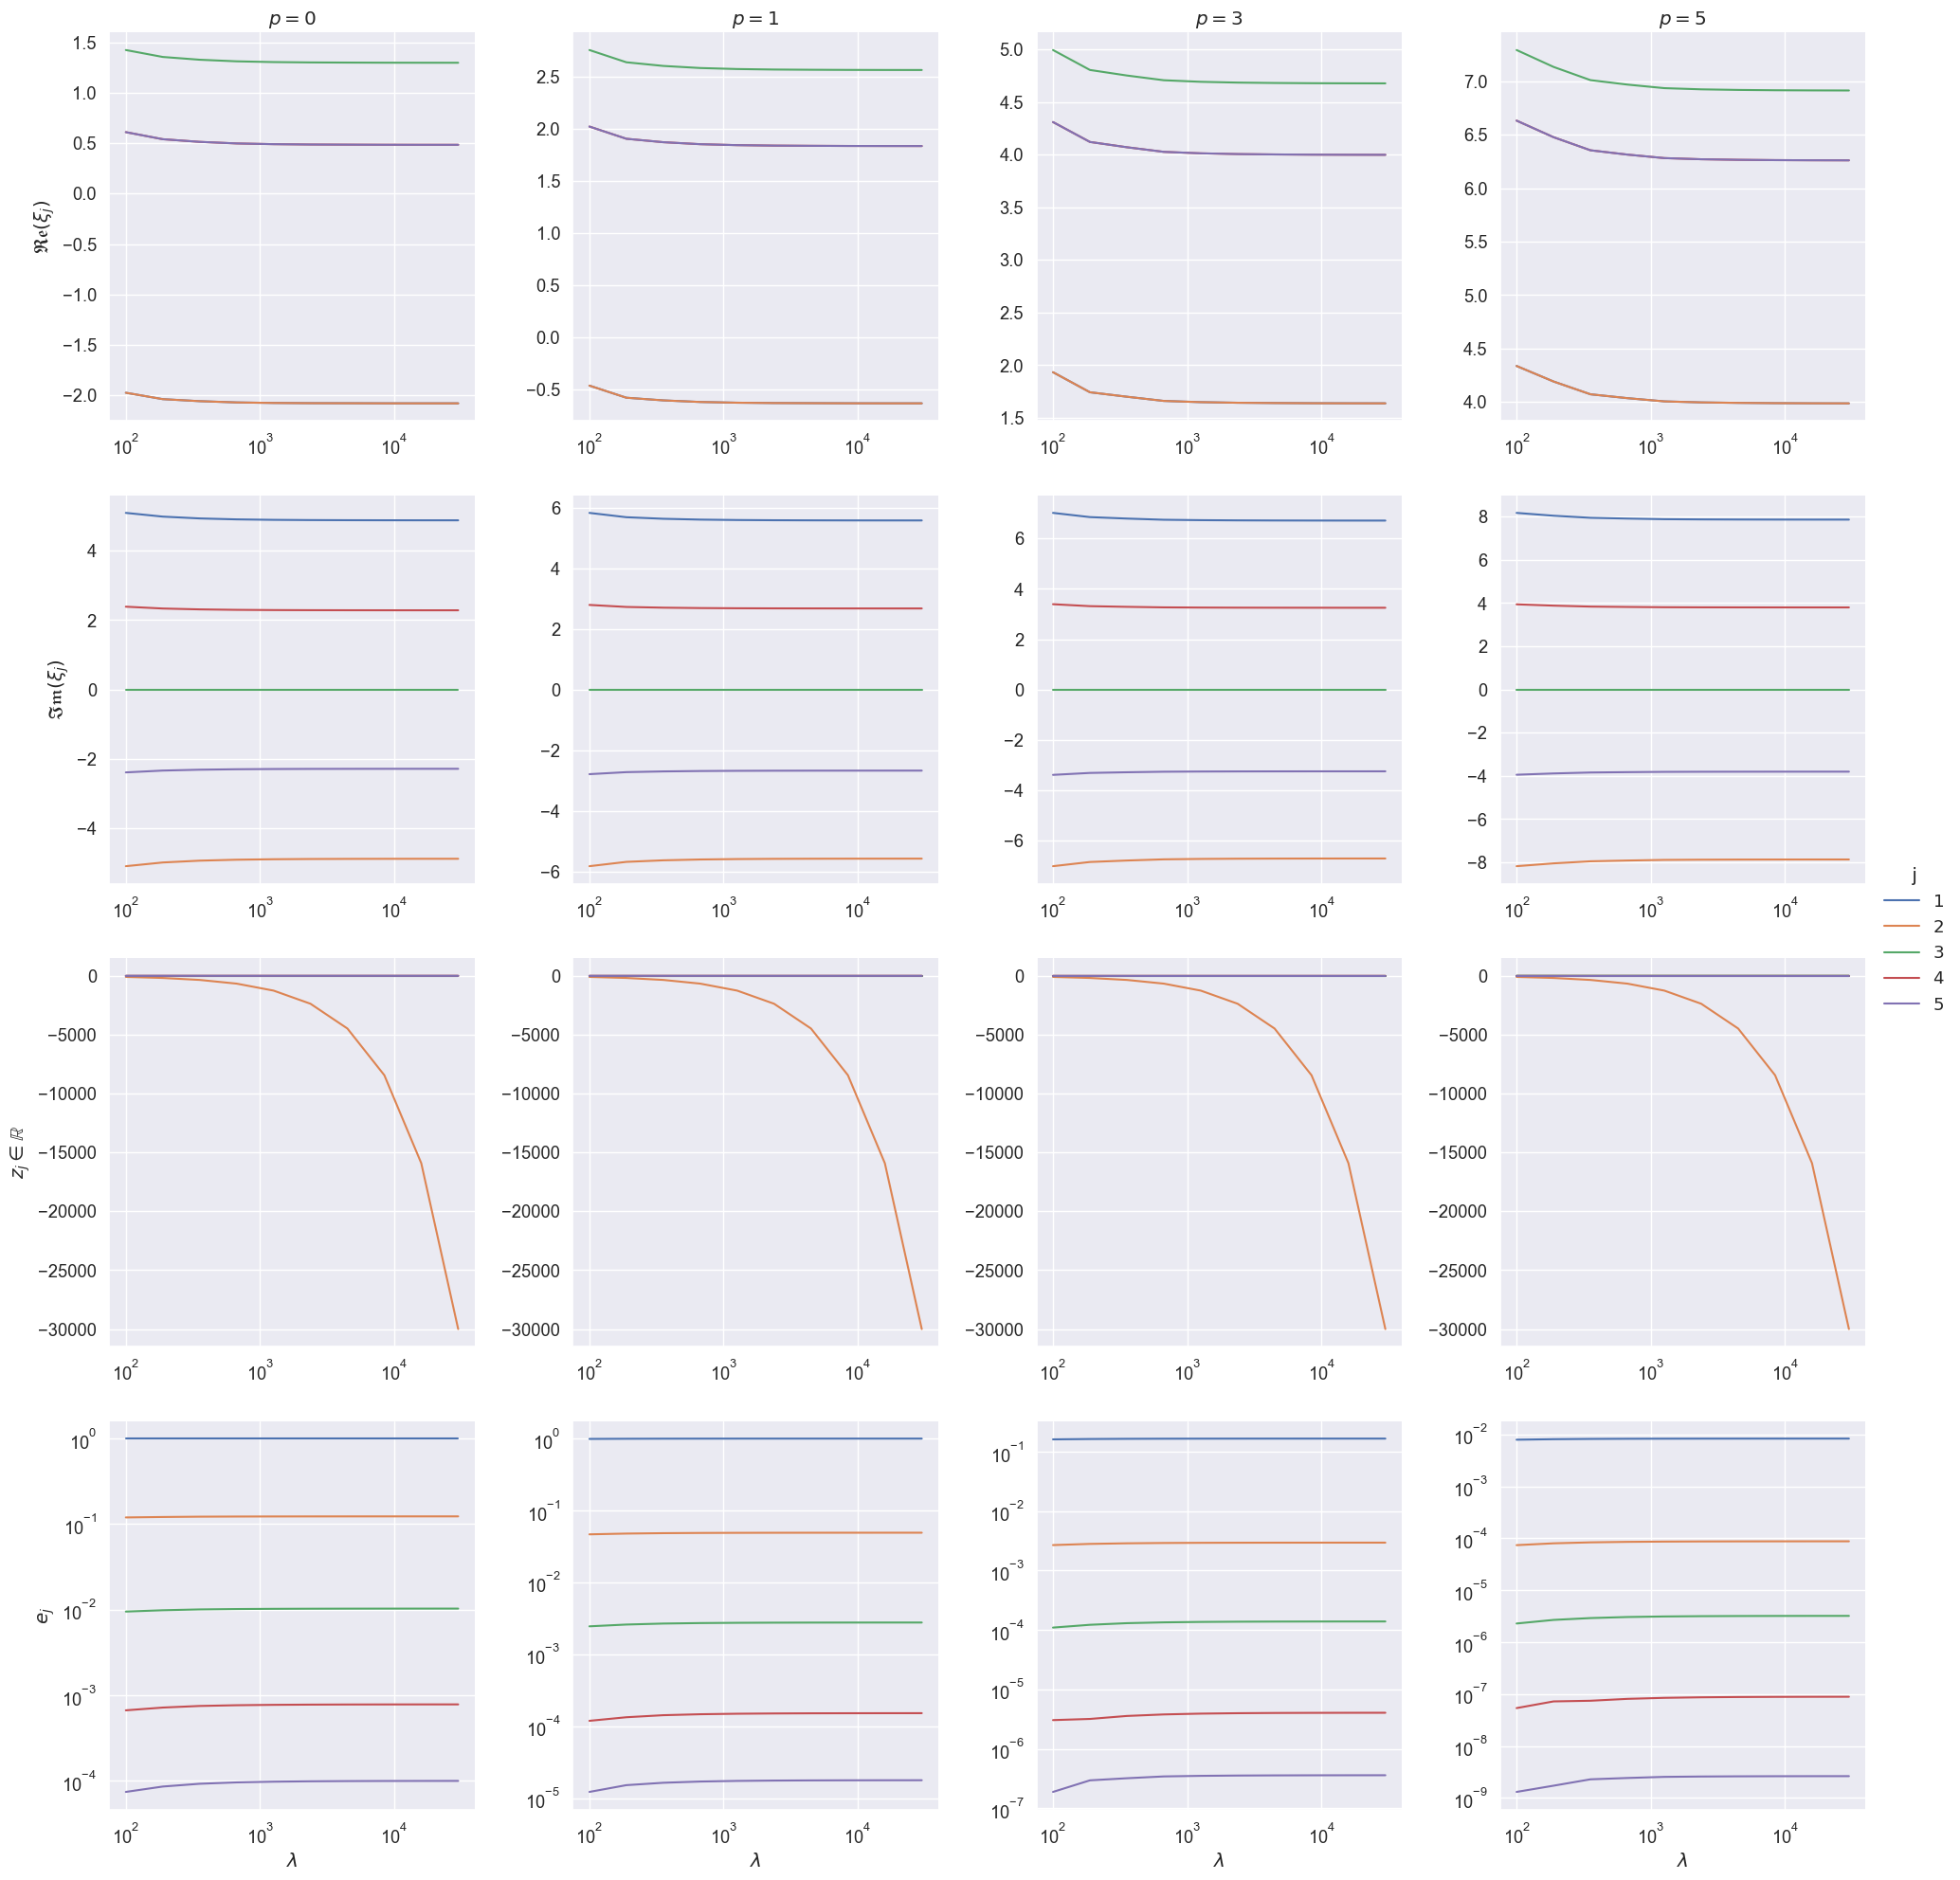

In [ ]:
sort = False
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_j$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

poles_real_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
poles_real_['what'] = '$\\mathfrak{Re}(\\xi_j)$'
df_real = pd.concat([data, poles_real_], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

poles_imag_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
poles_imag_['what'] = '$\\mathfrak{Im}(\\xi_j)$'
df_imag = pd.concat([data, poles_imag_], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

errors_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in errors] for m in range(m)})
errors_['what'] = '$e_j$'
df_errors = pd.concat([data, errors_], axis=1)
df_errors = df_errors.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df = pd.concat([df_real, df_imag, df_nodes, df_errors])
df['a'] = df['a'].abs()
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='$\\xi$',
    hue='j',
    row='what',
    col='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', ylabel='')

ps_ = list(set(ps))
for i, axs in enumerate(fg.axes):
    for j, ax in enumerate(axs):
        if i == 0:
            ax.set(title=f'$p = {ps_[j]}$')
        else:
            ax.set(title='')
        if i == 3:
            ax.set(yscale='log')

fg.axes[0, 0].set(ylabel='$\\mathfrak{Re}(\\xi_j)$');
fg.axes[1, 0].set(ylabel='$\\mathfrak{Im}(\\xi_j)$');
fg.axes[2, 0].set(ylabel='$z_j \\in \\mathbb{R}$');
fg.axes[3, 0].set(ylabel='$e_j$');

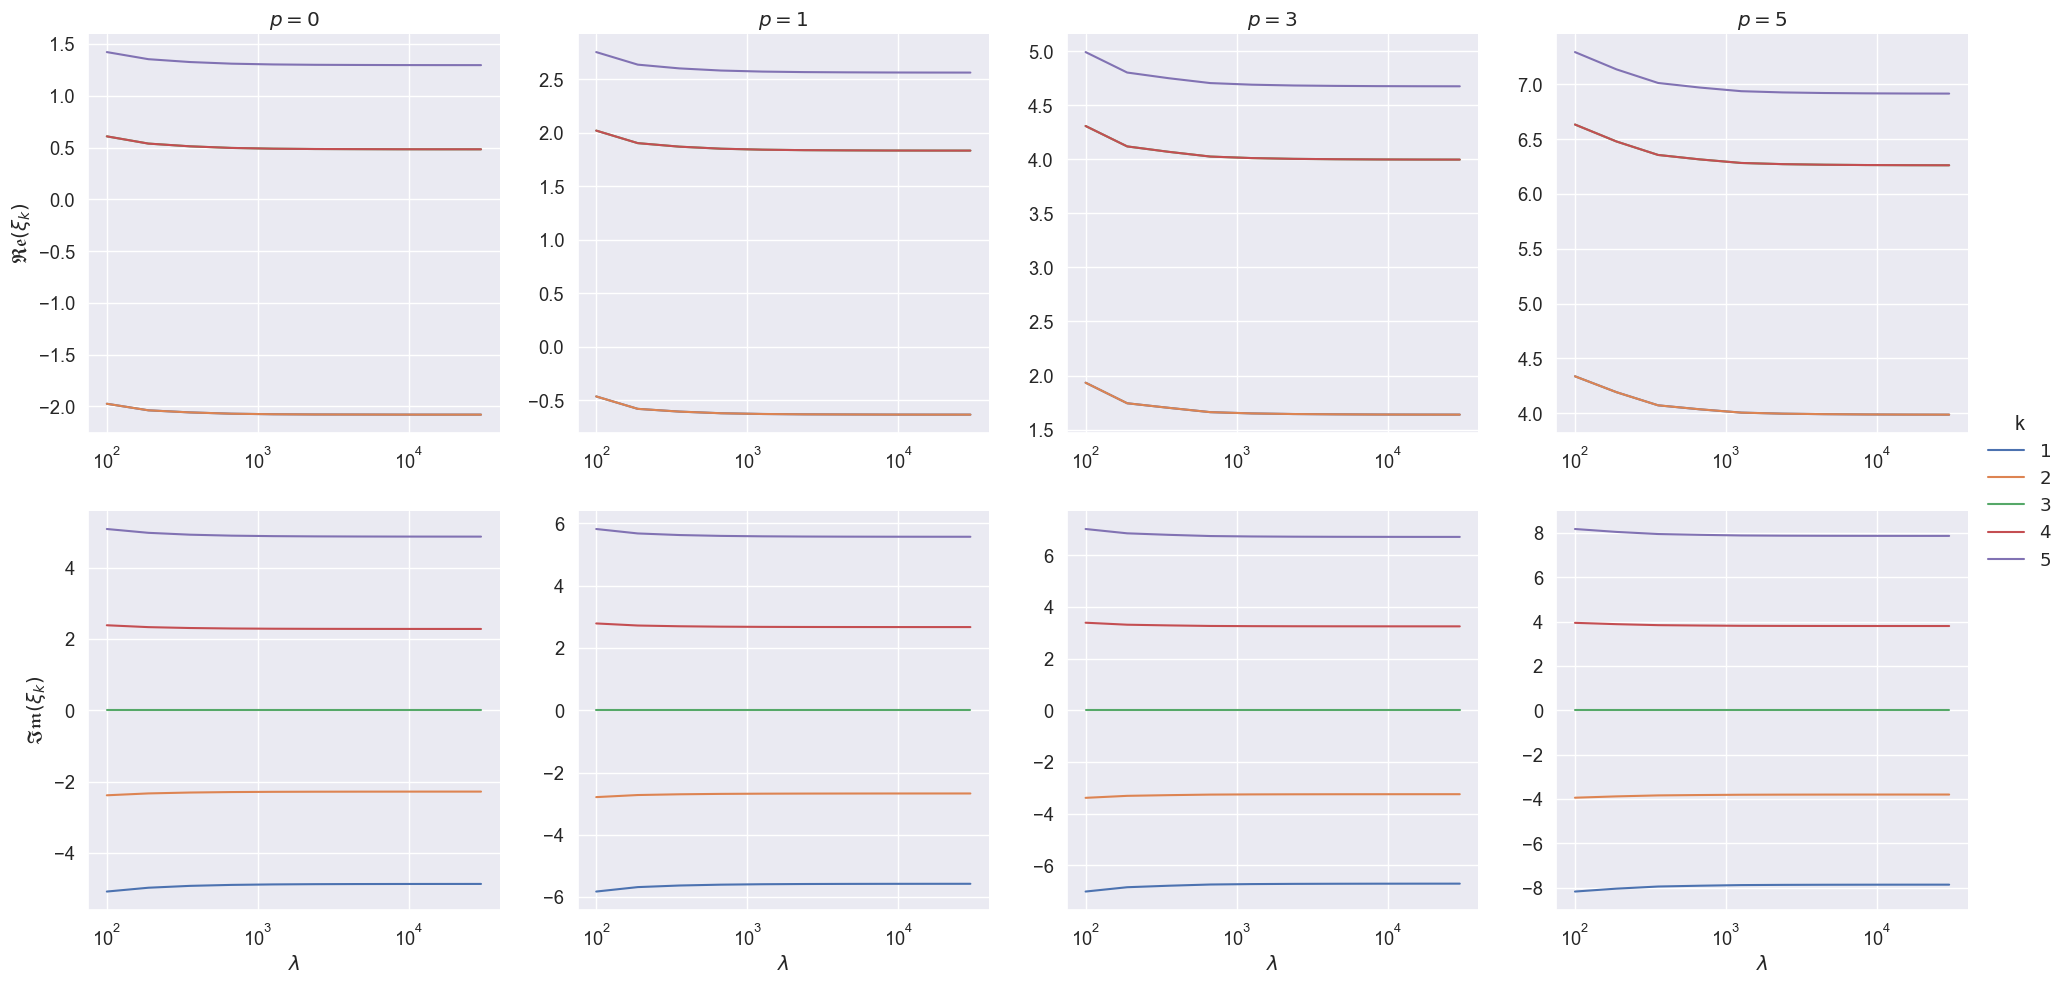

In [ ]:
sort = True
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_k$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

poles_real_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
poles_real_['what'] = '$\\mathfrak{Re}(\\xi_k)$'
df_real = pd.concat([data, poles_real_], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

poles_imag_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
poles_imag_['what'] = '$\\mathfrak{Im}(\\xi_k)$'
df_imag = pd.concat([data, poles_imag_], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df = pd.concat([df_real, df_imag])
df['a'] = df['a'].abs()
# df = df[(df['p'] == 3)]
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='$\\xi$',
    hue='k',
    row='what',
    col='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', title='')

fg.axes[0, 0].set(ylabel='$\\mathfrak{Re}(\\xi_k)$');
fg.axes[1, 0].set(ylabel='$\\mathfrak{Im}(\\xi_k)$');
ps_ = [0, 1, 3, 5]
for idx, ax in enumerate(fg.axes[0]):
    ax.set(title=f'$p={ps_[idx]}$');

## What happens to the maximum error with different discretizations?

In [5]:
m = 20

ps = []
as_ = []
methods = []
errors = []
for a in tqdm(np.geomspace(1e02, 3e04, 10)):
    Z_err = np.linspace(-a, 0, int(2 * a))
    for p in [0, 1, 3, 5]:
        f = Phi(p=p)

        Z = np.linspace(-a, 0, int(a))
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        ps.append(p)
        as_.append(a)
        methods.append('linspace($-\\lambda$, $0$, $\\lambda$)')
        errors.append(np.abs(f.scalar(Z_err) - r(Z_err)).max())

        Z = np.geomspace(-a, -1e-16, 4000)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        ps.append(p)
        as_.append(a)
        methods.append('geomspace($-\\lambda$, $-\\epsilon$, $4000$)')
        errors.append(np.abs(f.scalar(Z_err) - r(Z_err)).max())

        Z = np.linspace(-1000, 0, 2000)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        ps.append(p)
        as_.append(a)
        methods.append('linspace($-1000$, $0$, $2000$)')
        errors.append(np.abs(f.scalar(Z_err) - r(Z_err)).max())


  0%|          | 0/10 [00:00<?, ?it/s]

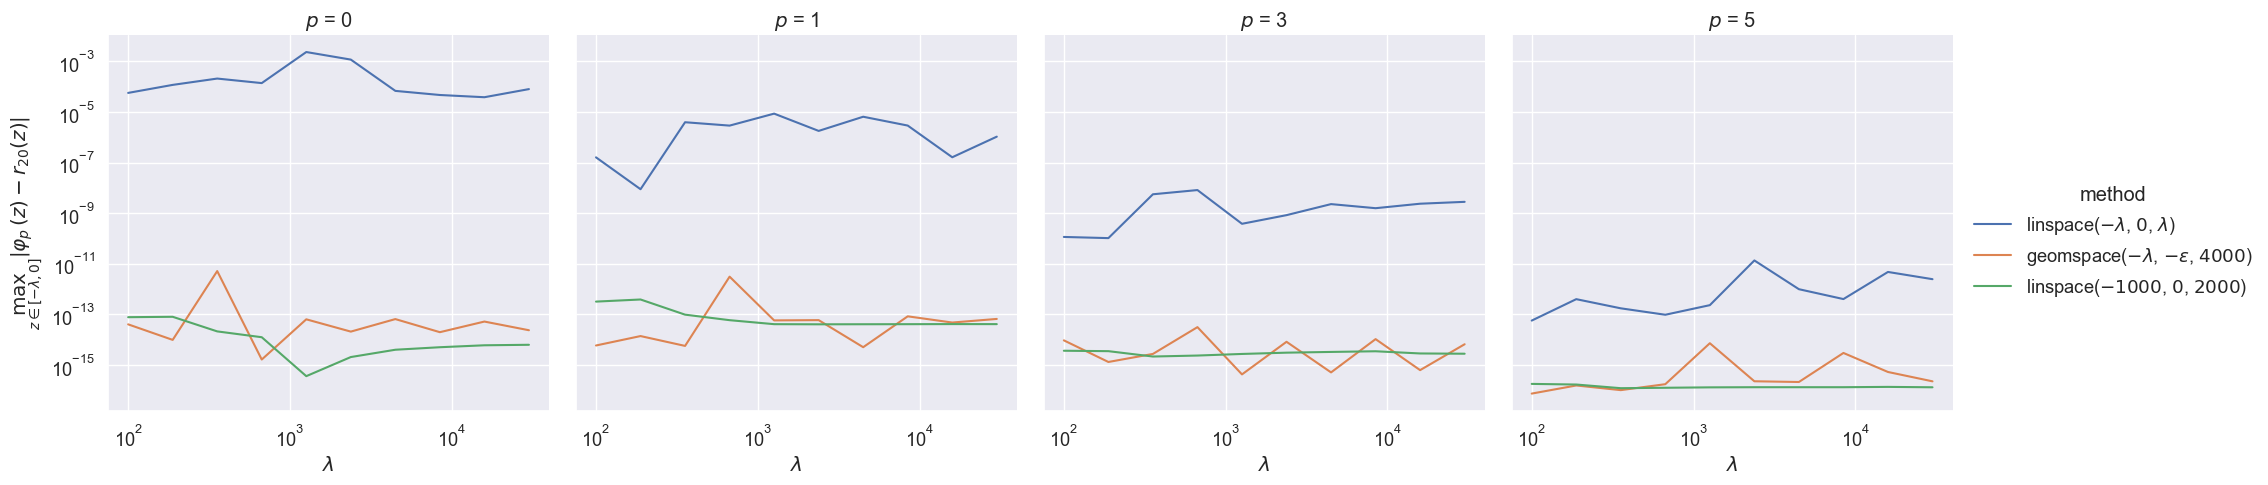

In [6]:
data = pd.DataFrame({'a': as_, 'p': ps, 'e': errors, 'method': methods})
df = data

fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='e',
    hue='method',
    col='$p$',
    kind='line',
    facet_kws={'sharex': True, 'sharey': True},
)
fg.set(xscale='log', yscale='log', ylabel='')

fg.axes[0, 0].set(ylabel=f'$\\max_{{z \\in [-\\lambda, 0]}} |\\varphi_p(z) - r_{{{m}}}(z)|$');

# Experiments

## With test matrices

In [ ]:
import warnings
warnings.filterwarnings('ignore')

mmax_PA = 600
mmax_RA = 100
# ns = [n ** 2 for n in range(100, 0, -10)]
ns = [n ** 2 for n in [100]]
as_ = [1e+03, 1e+04, 1e+05]
n_matrices = 1
ps = [0, 1, 3, 5]
nms = 50

ds = []
pbar_n = tqdm(total=len(ns), desc='Sizes (n)', leave=True)
for n in ns:
    pbar_n.desc = f'Sizes (n={n})'
    pbar_n.refresh()

    # Get random vector v and normalize it
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)

    # Set the name of the test matrices
    names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']

    # Get the eigenvalues of A1 and A2
    eigs = {}
    A1 = get_FD_matrix(n=n, d=1, scale=False)
    eigs['A1'] = (
        sps.linalg.eigsh(A1, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A1, k=1, which='LA', return_eigenvectors=False).item(),
    )
    A2 = get_FD_matrix(n=(n ** .5), d=2, scale=False)
    eigs['A2'] = (
        sps.linalg.eigsh(A2, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A2, k=1, which='LA', return_eigenvectors=False).item(),
    )

    pbar_a = tqdm(total=len(as_), desc='Eigenvalues (a)', leave=False)
    for a in as_:
        pbar_a.desc = f'Eigenvalues (a={a:.0e})'
        pbar_a.refresh()

        interval = (-a, 0)
        matrices = get_test_matrices(n=n, interval=interval, eigs=eigs)
        intervals = [interval] * 5

        # Get convergence data for the test matrices
        pbar_A = tqdm(total=n_matrices, desc='Matrices (A)', leave=False)
        for name, A, interval in zip(names[:n_matrices], matrices[:n_matrices], intervals[:n_matrices]):
            pbar_A.desc = f'Matrices (A={name})'
            pbar_A.refresh()

            pbar_p = tqdm(total=len(ps), desc='Phi-function (p)', leave=False)
            for p in ps:
                pbar_p.desc = f'Phi-function (p={p})'
                pbar_p.refresh()
                d = get_convergence(
                    A=A,
                    v=v,
                    nms=nms,
                    funcs=[
                        Phi(p=p)
                        # Cosine(t=t),
                        # Sine(t=t),
                        # Sinc(t=t),
                        # Sinc2(t=t)
                    ],
                    # funcs=[Phi(p=p, t=t) for p in [0, 1, 3, 5]],
                    mmax_PA=min(n - 20, mmax_PA),
                    mmax_RA=min(n - 20, mmax_RA),
                    interval=interval,
                )
                d['name'] = [name] * len(d['err'])
                d['n'] = [n] * len(d['err'])
                d['a'] = [f'{a:.0e}'] * len(d['err'])
                d['p'] = [f'{p}'] * len(d['err'])
                ds.append(d)
                pbar_p.update()

            pbar_p.close()
            pbar_A.update()

        pbar_A.close()
        pbar_a.update()

    pbar_a.close()
    pbar_n.update()

pbar_n.close()
warnings.filterwarnings('default')

print('Done!')

In [5]:
# Build the dataframe
df = pd.concat([pd.DataFrame(d) for d in ds])

## With the linear elasticity matrices

In [ ]:
import warnings
warnings.filterwarnings('ignore')

mmax_PA = 400
mmax_RA = 400
ts = [
    5e-05,
    1e-04,
    1e-03,
    1e-01,
    # 1e-00
]
nms = 30

# Set the test matrices
hs = [
    0.04,
    0.07,
    0.1,
]
names = [f'$H_{{LE}}^{{h={h:.2f}}}$' for h in hs]
matrices = [A_LE[h]['H'].toarray() for h in hs]
vectors = [(A_LE[h]['u0'], A_LE[h]['v0'], A_LE[h]['b']) for h in hs]
intervals = [(A_LE[h]['dH'].min(), A_LE[h]['dH'].max()) for h in hs]

ds = []
pbar_A = tqdm(total=len(matrices), desc='Matrices (A)', leave=True)
for name, A, vectors, interval in zip(names, matrices, vectors, intervals):
    pbar_A.desc = f'Matrices (A={name})'
    pbar_A.refresh()

    # Get random vector v and normalize it
    n = A.shape[0]
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)
    u0, v0, b0 = vectors

    pbar_p = tqdm(total=len(ts), desc='Time steps (t)', leave=False)
    for t in ts:
        pbar_p.desc = f'Time steps (t={t:.0e})'
        pbar_p.refresh()
        d = get_convergence(
            A=A,
            v=v,
            nms=nms,
            funcs=[
                Cosine(t=t),
                Sine(t=t),
                Sinc(t=t),
                Sinc2(t=t)
            ],
            mmax_PA=min(n-20, mmax_PA),
            mmax_RA=min(n-20, mmax_RA),
            interval=interval,
        )
        d['name'] = [name] * len(d['err'])
        d['n'] = [n] * len(d['err'])
        d['t'] = [f'{t:.0e}'] * len(d['err'])
        ds.append(d)

        pbar_p.update()

    pbar_p.close()
    pbar_A.update()

pbar_A.close()

warnings.filterwarnings('default')

print('Done!')

In [ ]:
# Build the dataframe
df = pd.concat([pd.DataFrame(d) for d in ds])

## IO of the results

In [3]:
file = 'experiments_.csv'

In [10]:
# Save the experiments
df.to_csv(file, index=False)

In [4]:
# Load the experiments
df = pd.read_csv(file)

# Plots

## Convergence of trigonometric functions

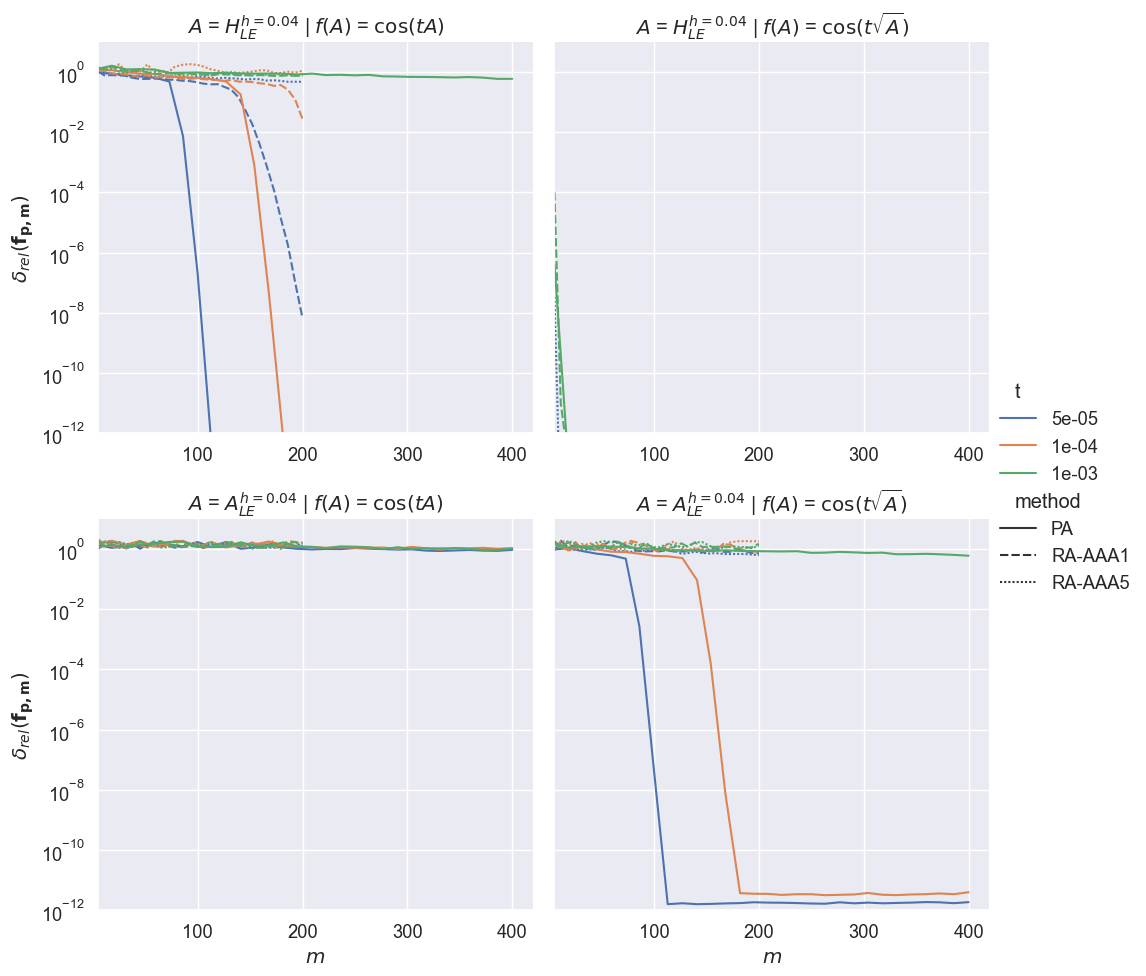

In [12]:
data = df[
    # Method
    ((df['method'] != 'EX'))
    # & ((df['method'] == 'PA') | (df['method'] == 'RA-AAA1'))
    # &((df['name'] == '$A_2$'))
]

# data.loc[data['f'] == '$cos(tA)$', 'f'] = '$\\cos(t\\sqrt{A})$'
# data.loc[data['f'] == '$t sinc(tA)$', 'f'] = '$t \\mathrm{sinc}(t\\sqrt{A})$'
# data.loc[data['f'] == '$\\frac{t^2}{2} sinc(\\frac{t}{2} A)^2$', 'f'] = '$\\frac{t^2}{2} \\mathrm{sinc}^2(\\frac{t}{2} \\sqrt{A})$'
# data.loc[data['t'] == 5e-05, 't'] = '5e-05'
# data.loc[data['t'] == 1e-04, 't'] = '1e-04'
# data.loc[data['t'] == 1e-03, 't'] = '1e-03'


fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'm': '$m$', 'f': '$f(A)$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='t',
    # row='$A$',
    col='$f(A)$',
    style='method',
    row='$A$',
    palette='deep',
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\mathbf{f_{p, m}})$',
)

## Convergence for different $\varphi$-functions

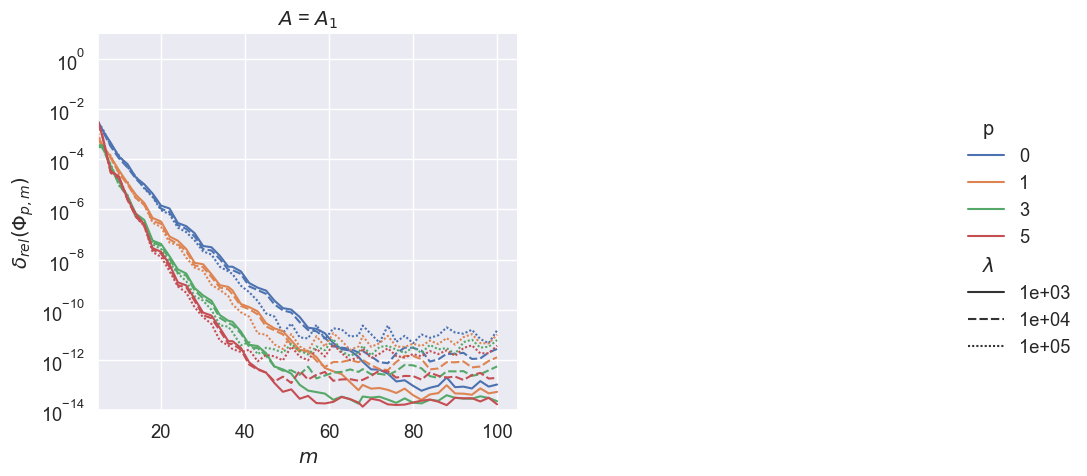

In [7]:
data = df[
    ((df['method'] == 'RA-ONES'))
    & ((df['name'] != 'bound'))
    & (df['n'] == 10000)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    style='$\\lambda$',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-14, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
);

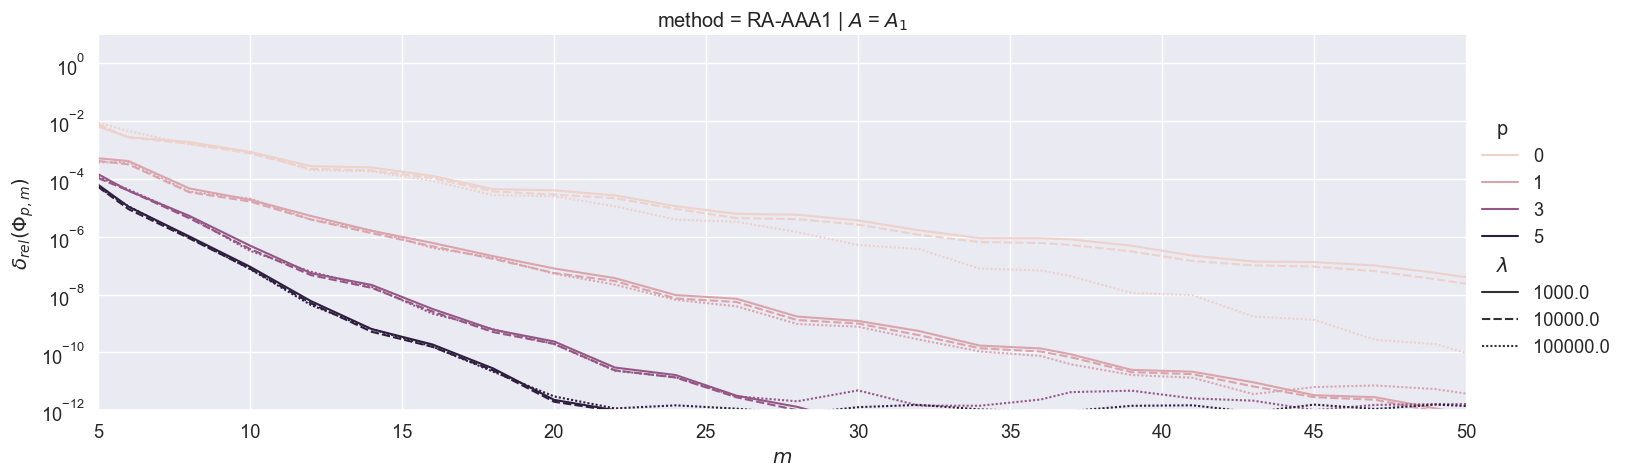

In [15]:
data = df[
    # phi functions
    (df['p'] != 10)

    # Method
    & ((df['method'] == 'RA-AAA1'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == 10000) | (df['a'] == 5000) | (df['a'] == 1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 3600) & (df['m'] > 300))
    # & (df['m'] < 600)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    row='method',
    style='$\\lambda$',
    # col_wrap=2,
    facet_kws={'sharex': False},
    height=5,
    aspect=3,
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
);
fg.axes[0, 0].set(xlim=[5, 50]);

## Convergence for different matrices

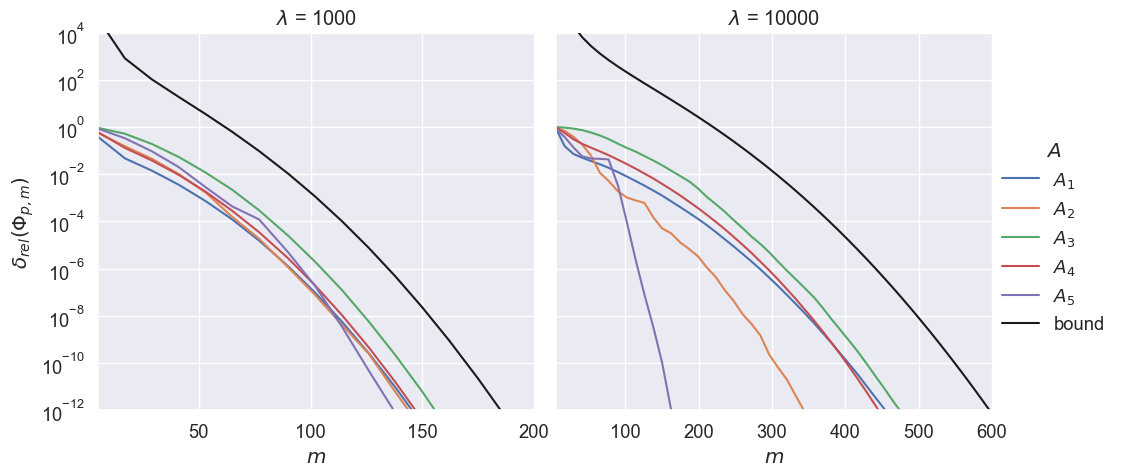

In [15]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & ((df['n'] == 10000))

    # Smallest eigenvalue
    & ((df['a'] == 10000) | (df['a'] == 1000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='$A$',
    # style='p',
    col='$\\lambda$',
    col_wrap=2,
    hue_order=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$', 'bound'],
    col_order=[1000, 10000],
    facet_kws={'sharex': False},
    palette=['C0', 'C1', 'C2', 'C3', 'C4', 'k'],
)
ax = plt.gca()
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+04],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
);
fg.axes[0].set(xlim=[5, 200]);
fg.axes[1].set(xlim=[5, 600]);

## Convergence with different methods

IndexError: index 1 is out of bounds for axis 0 with size 1

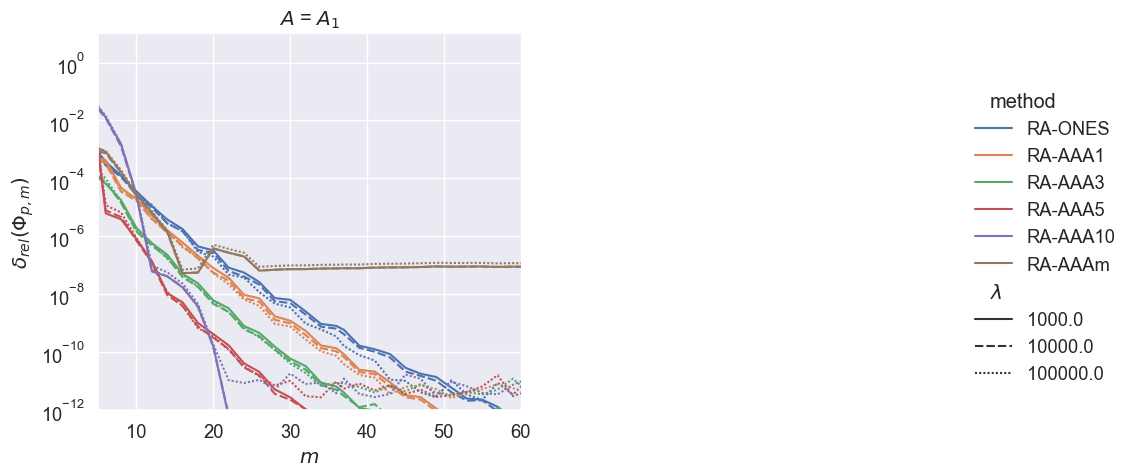

In [16]:
# TODO: Use this for comparing RA and RA-AAA
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] != 'EX') & (df['method'] != 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    style='$\\lambda$',
    col='$A$',
    hue='method',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)
fg.axes[0].set(xlim=[5, 60])
fg.axes[1].set(xlim=[5, 30])
fg.axes[2].set(xlim=[5, 40])
fg.axes[3].set(xlim=[5, 60])
fg.axes[4].set(xlim=[5, 20])

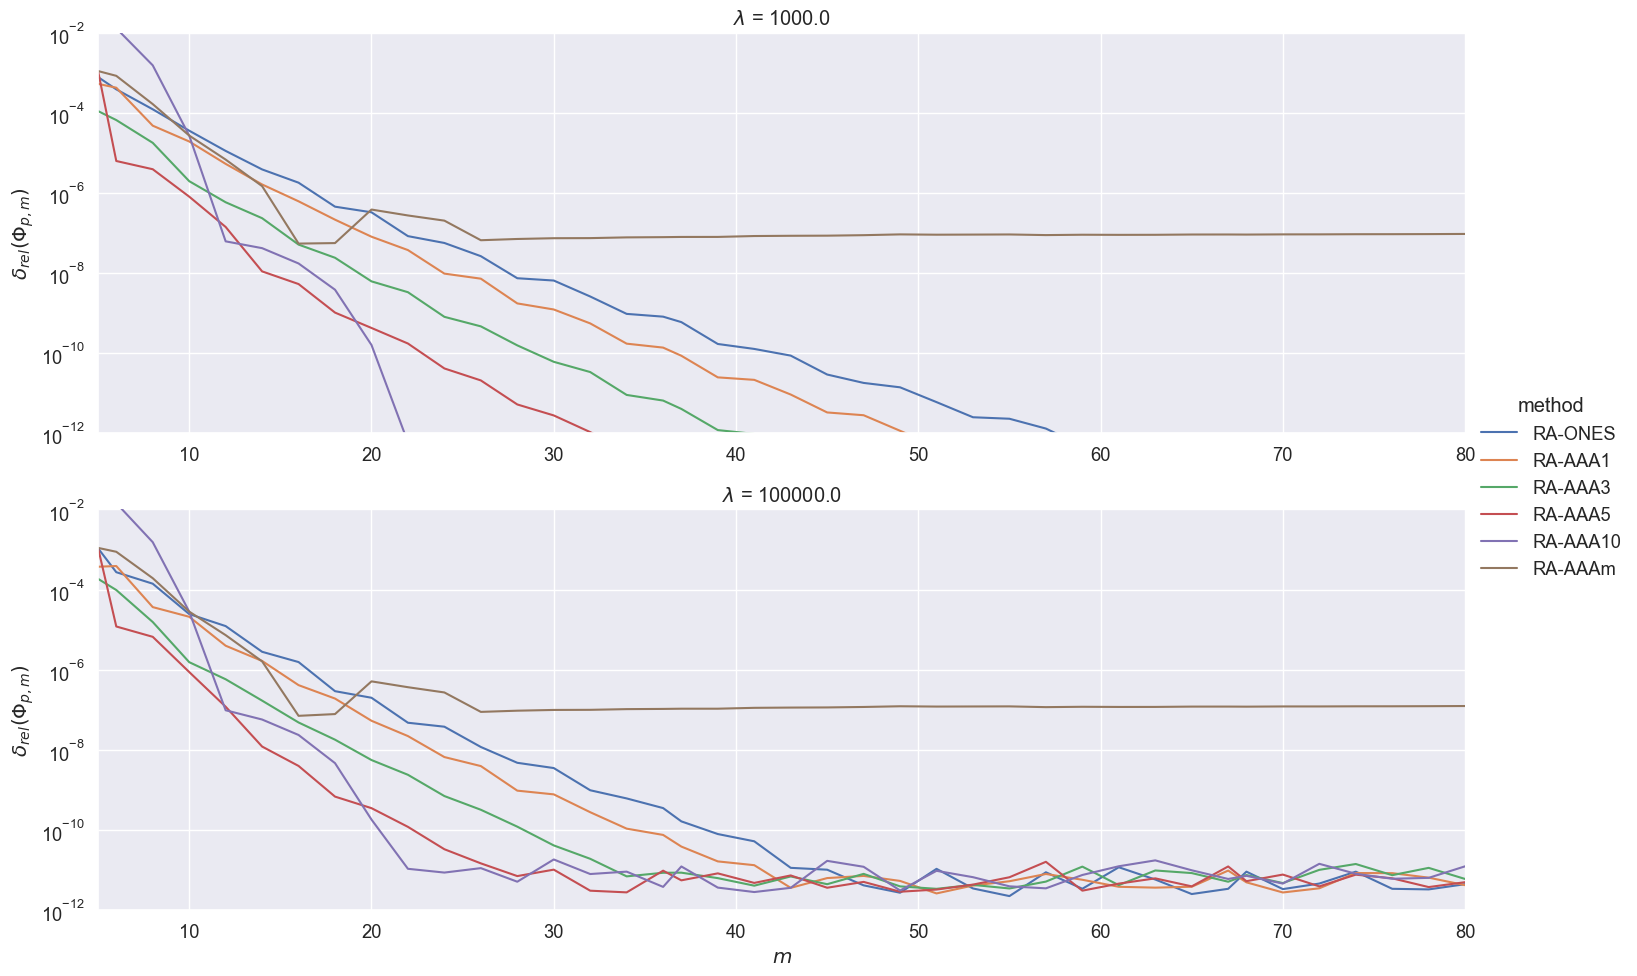

In [20]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & (((df['method'].str.contains('AAA'))) | (df['method'] == 'RA-ONES'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    & ((df['a'] == 100000) | (df['a'] == 1000))
].copy()

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    row='$\\lambda$',
    # col='$A$',
    hue='method',
    # col_wrap=2,
    height=5,
    aspect=3,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, 80],
    ylim=[1e-12, 1e-02],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

## Convergence with different n

Show that RA has mesh-independent convergence, whereas PA does not. Cite the review paper of Guttel for that.

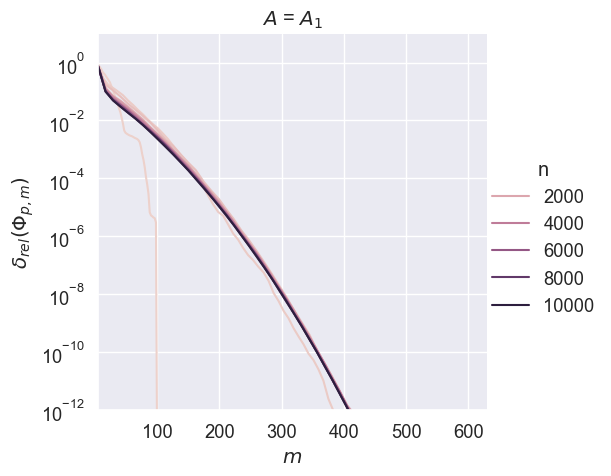

In [130]:
data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    # & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == 10000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='n',
    # col='method',
    row='$A$',
    # col_wrap=2,
    # facet_kws={'sharex': False}
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

## CPU time with different n

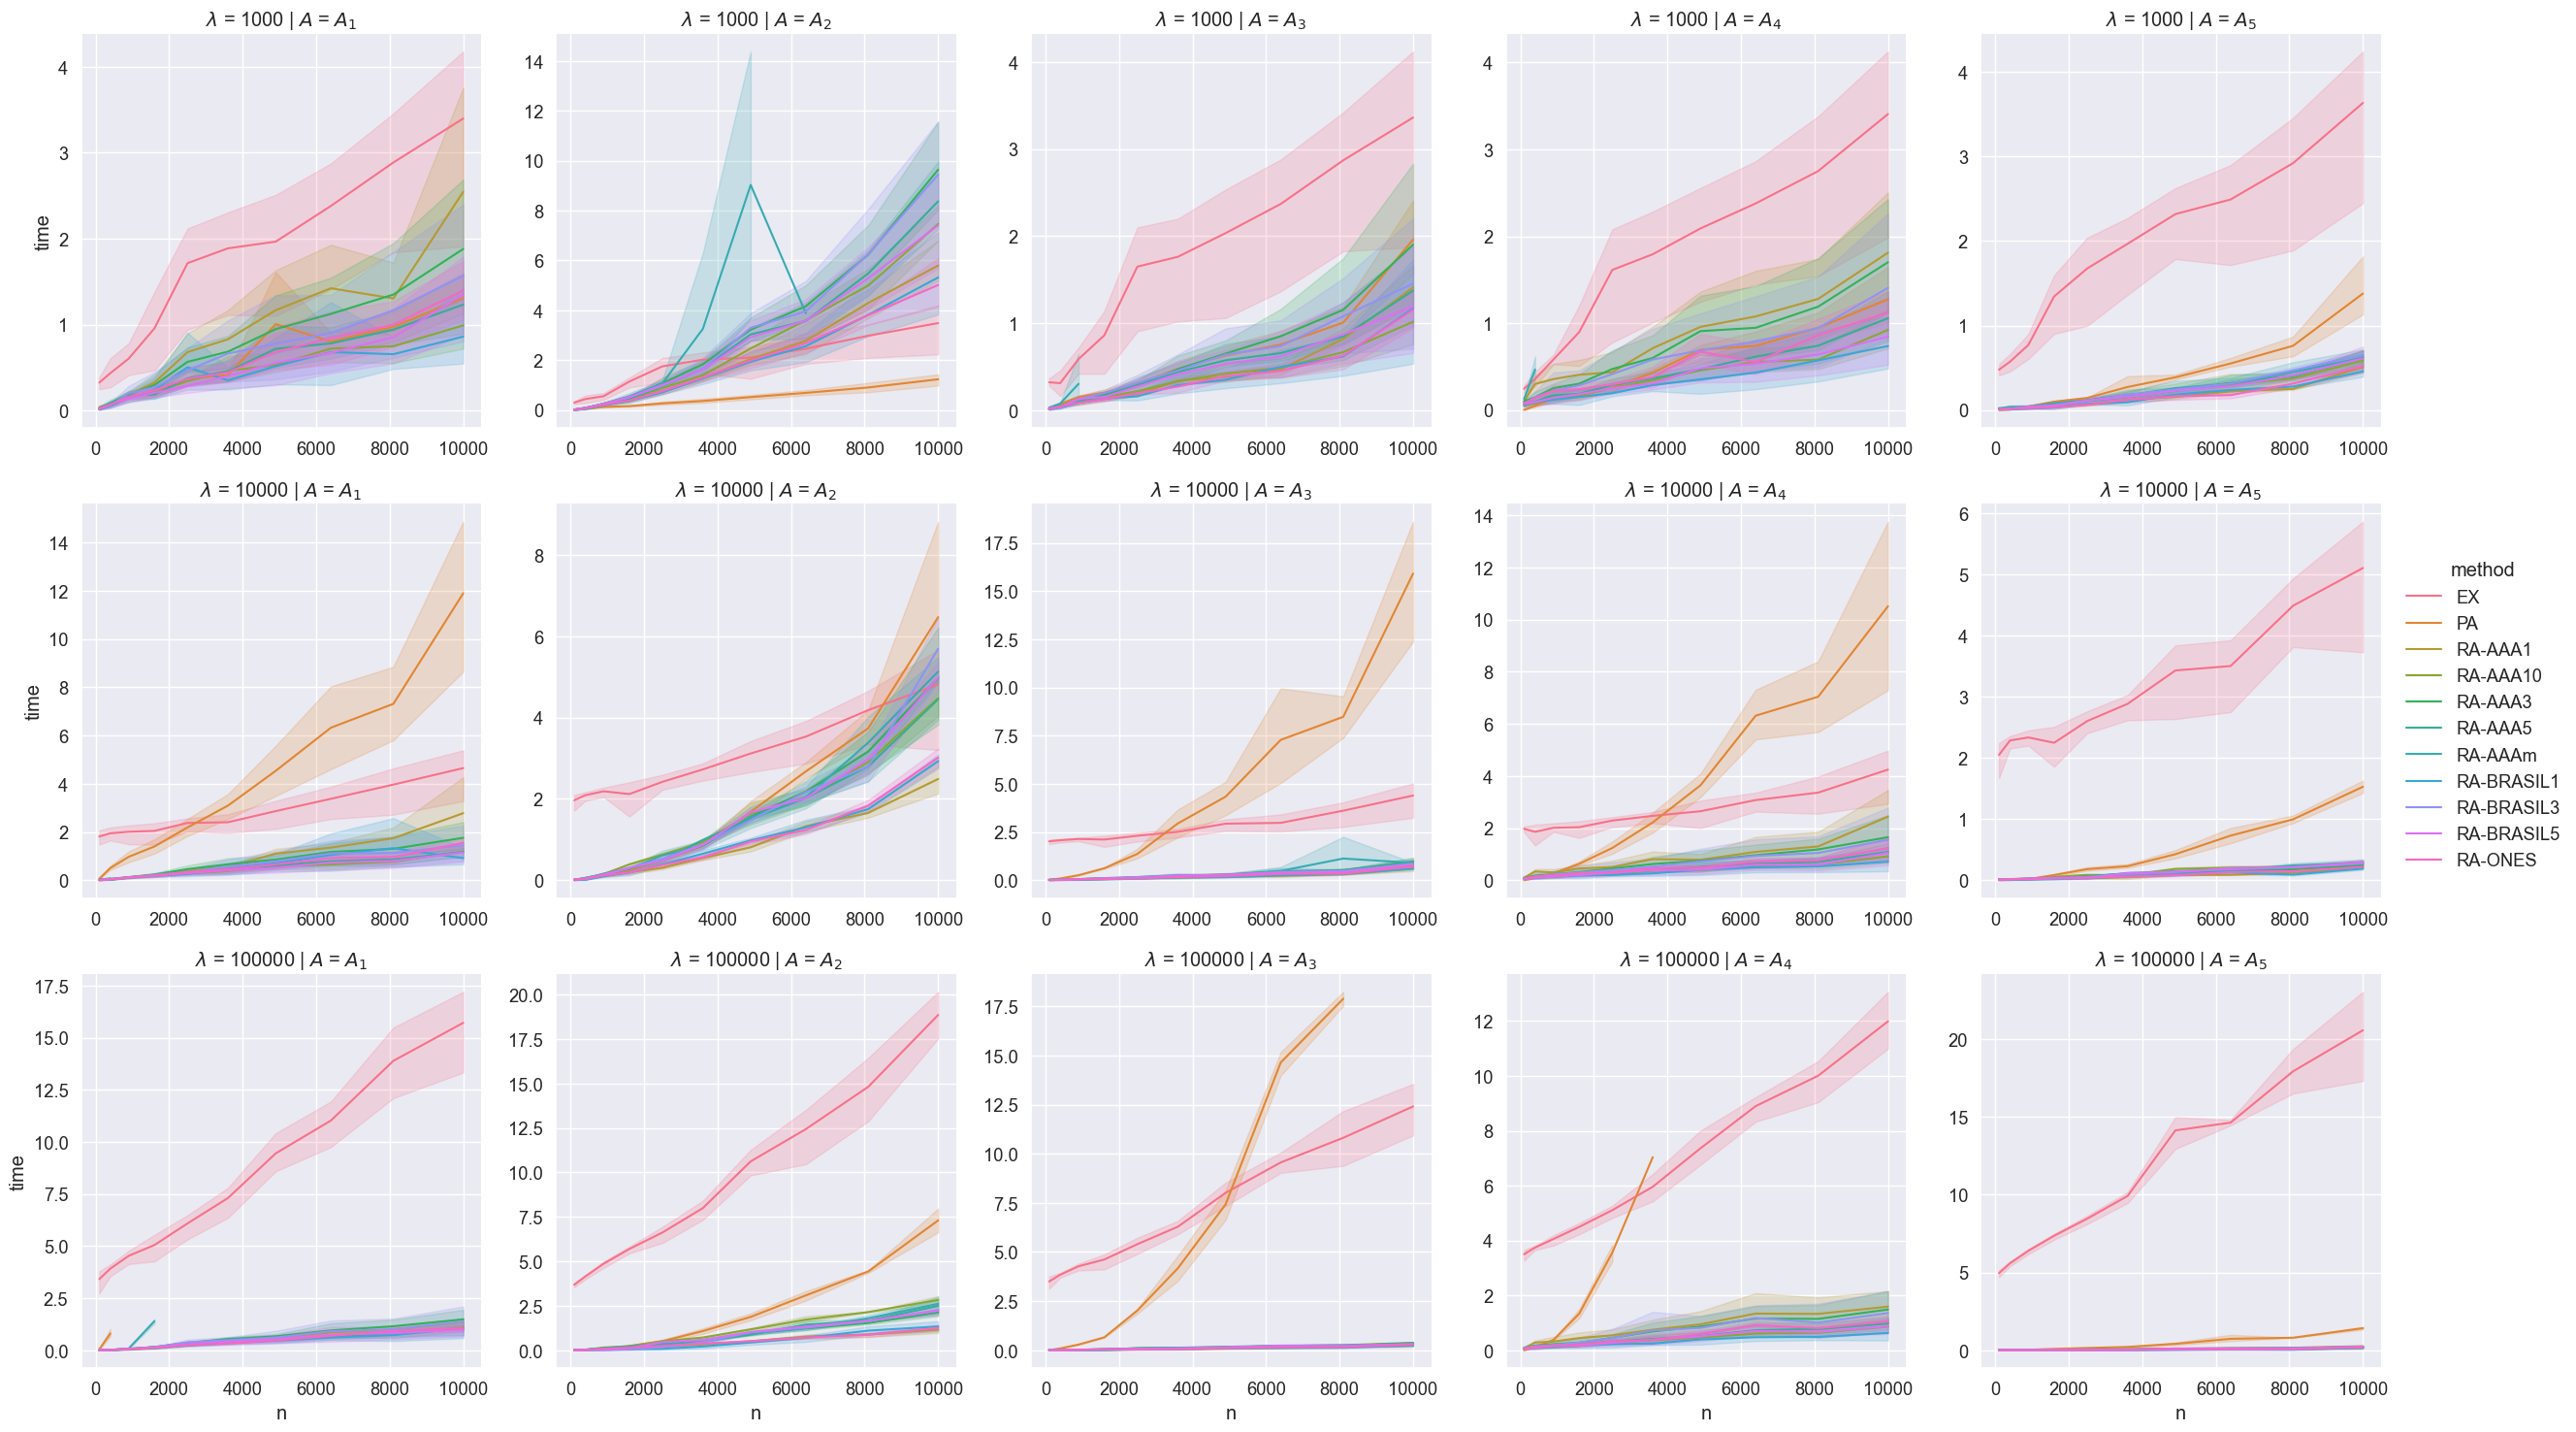

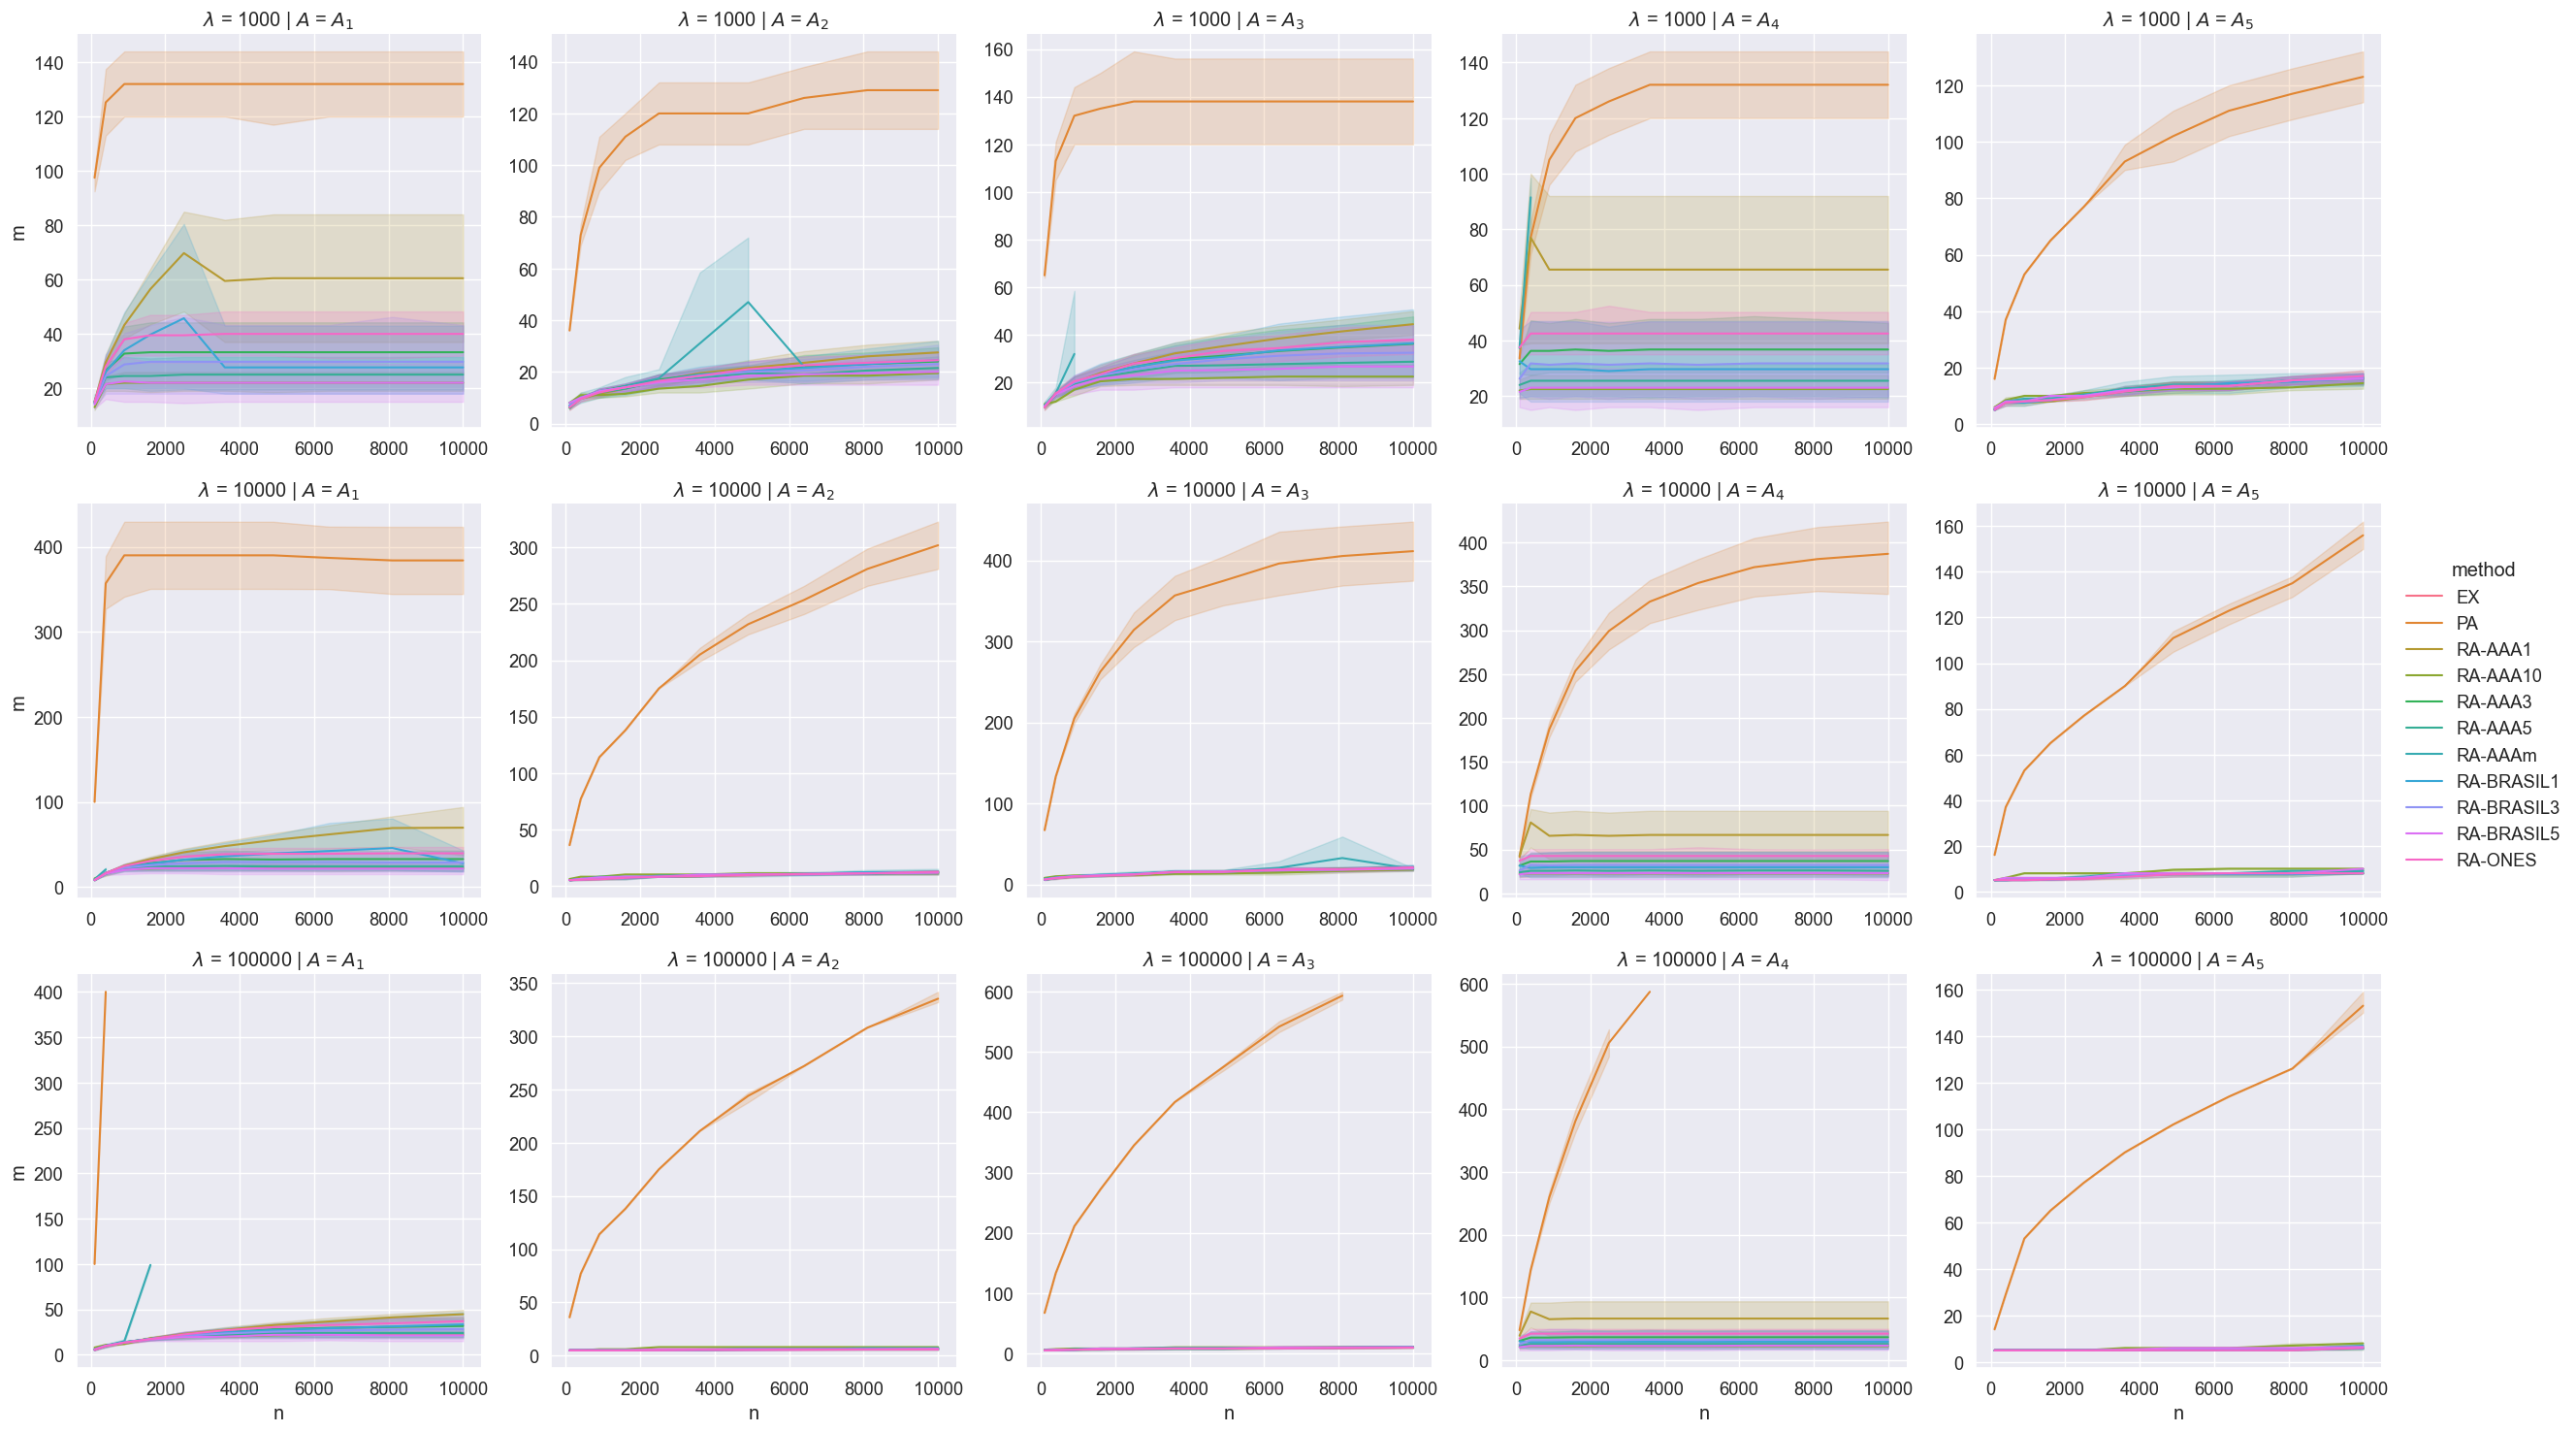

In [146]:
data = df[
    ((df['name'] != 'bound'))
    # & ((df['p'] == 5))
    # & ((df['method'].str.contains('RA')))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)

# Plot CPU time
fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

# Plot smallest m
fg = sns.relplot(
    data=data,
    x='n',
    y='m',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

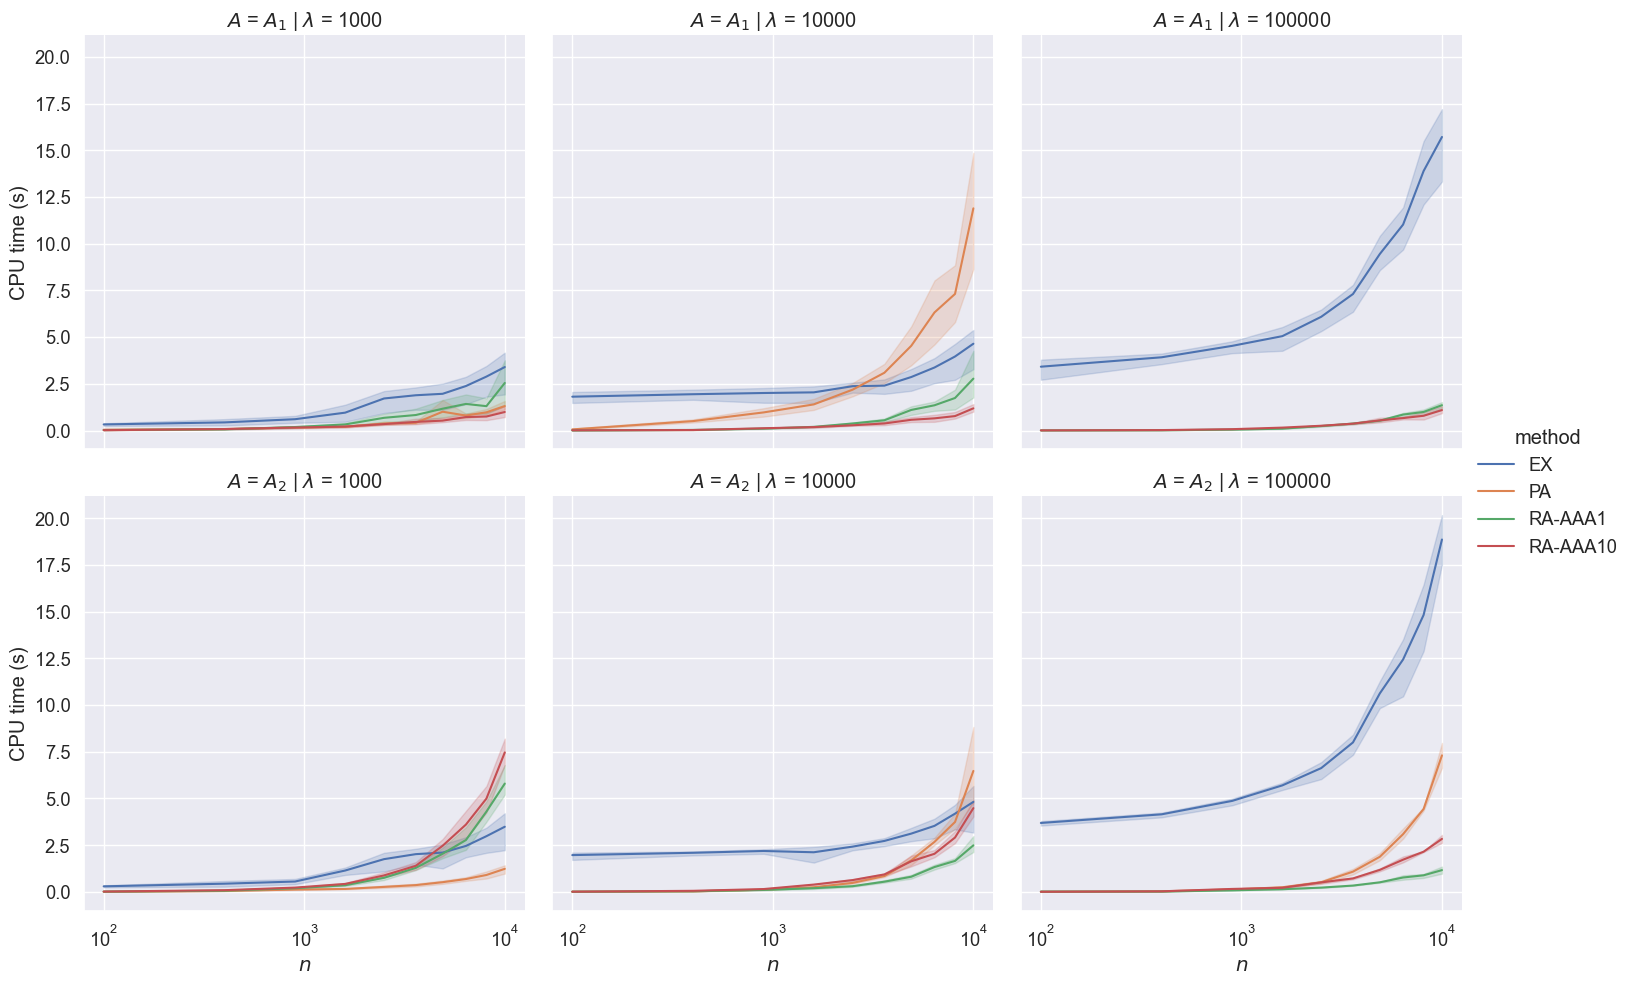

In [158]:
data = df[
    ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))
    & ((df['method'] == 'EX') | (df['method'] == 'PA') | (df['method'] == 'RA-AAA1') | (df['method'] == 'RA-AAA10'))
    & ~((df['a'] == 100000) & (df['method'] == 'PA') & (df['name'] == '$A_1$'))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)


fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    row='$A$',
    col='$\\lambda$',
    col_order=[1000, 10000, 100000],
    # facet_kws={'sharey': False}
)
fg.set(
    xscale='log',
    ylabel='CPU time (s)',
    xlabel='$n$',
)